In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt
from scipy import optimize
from scipy.linalg import det
import sys
sys.path.append('../')

from scripts.compute_covariance import compute_covariance

In [178]:
nside=256
npix=hp.nside2npix(nside)
freqs=np.arange(544,1088,step=10)
nfreqs=len(freqs)-1
lmax=3*nside -1
almsize=hp.Alm.getsize(lmax)
ells=np.arange(2,lmax+1)

Rescaled foregrounds to be lower with the assumption we are using a cut sky

In [3]:
cl_hi_1=np.load("/home/iloveorcas/MASS_Thesis/HI/cal_hi_cov.npy")
cl_hi = np.transpose(cl_hi_1, (2, 0, 1))
hi_maps= np.load("HI_map_cal.npy")
# ff=np.load("/home/iloveorcas/MASS_Thesis/results_2/ff_maps.npy")
# sync=np.load("/home/iloveorcas/MASS_Thesis/results_2/sync_maps.npy")
ff=np.load("/home/iloveorcas/MASS_Thesis/results_2/smoothed_ff_maps.npy")
sync=np.load("/home/iloveorcas/MASS_Thesis/results_2/smoothed_sync_maps.npy")
# hi_maps= np.load("/home/iloveorcas/MASS_Thesis/results_2/smoothed_hi_maps.npy")
noise_maps= np.load("/home/iloveorcas/MASS_Thesis/results_2/noise_nf.npy")

fgds=(ff+sync)/3e8
# cl_hi=compute_covariance(hi_maps, lmax, almsize, nfreqs)
cl_noise= compute_covariance(noise_maps, lmax, almsize, nfreqs)
cl_fgds= compute_covariance(fgds, lmax, almsize, nfreqs)

Converting maps 0
Converting maps 1
Converting maps 2
Converting maps 3
Converting maps 4
Converting maps 5
Converting maps 6
Converting maps 7
Converting maps 8
Converting maps 9
Converting maps 10
Converting maps 11
Converting maps 12
Converting maps 13
Converting maps 14
Converting maps 15
Converting maps 16
Converting maps 17
Converting maps 18
Converting maps 19
Converting maps 20
Converting maps 21
Converting maps 22
Converting maps 23
Converting maps 24
Converting maps 25
Converting maps 26
Converting maps 27
Converting maps 28
Converting maps 29
Converting maps 30
Converting maps 31
Converting maps 32
Converting maps 33
Converting maps 34
Converting maps 35
Converting maps 36
Converting maps 37
Converting maps 38
Converting maps 39
Converting maps 40
Converting maps 41
Converting maps 42
Converting maps 43
Converting maps 44
Converting maps 45
Converting maps 46
Converting maps 47
Converting maps 48
Converting maps 49
Converting maps 50
Converting maps 51
Converting maps 52
Con

In [246]:
def bin_spectra(cl, delta):
    b= nmt.NmtBin.from_lmax_linear(lmax, nlb=delta)
    n_bins = b.get_n_bands()
    leff = b.get_effective_ells()
    cl_binned= np.zeros((n_bins, nfreqs, nfreqs))

    for i in range(nfreqs):
        for j in range(nfreqs):
            cl_binned[:, i, j] = b.bin_cell(cl[:, i, j])
            
    return leff,n_bins,cl_binned

In [247]:
leff, nbins,hi_binned= bin_spectra(cl_hi, 10)
*_,noise_binned= bin_spectra(cl_noise, 10)
*_, fgds_binned= bin_spectra(cl_fgds, 10)
# total=hi_maps + noise_maps[:54]
# cl_hat=compute_covariance(total, lmax, almsize, nfreqs)
# *_, chat_binned= bin_spectra(cl_hat, 10)

In [248]:
def diagonalize_matrices(cl, nfreqs):
    cl_diag=np.zeros((nbins, nfreqs, nfreqs))
    for l in range (nbins):
        #print(f"Diagonalizing matrix {l}")
        cl_diag[l,:,:]= np.identity(nfreqs)*cl[l,:,:]
    return cl_diag
hi_d= diagonalize_matrices(hi_binned, nfreqs)
#print(hi_d[10])

In [394]:
bins=12

In [395]:
def build_trapezoidal_basis(freqs, bin, top_width=0.5):
    """
    Create trapezoidal basis functions (___/----\___) on frequency grid.
    
    Parameters:
    - freqs: 1D array of frequency bin centers (nf,)
    - n_bins: number of trapezoidal functions (i.e., nq)
    - top_width: fraction of bin width used for the flat top (0 < top_width < 1)

    Returns:
    - phi: shape (n_bins, nf), the basis matrix
    """
    nf = len(freqs)
    vmin, vmax = freqs[0], freqs[-1]
    bin_edges = np.linspace(vmin, vmax, bins + 1)
    bin_width = bin_edges[1] - bin_edges[0]
    flat_top = top_width * bin_width
    slope_width = (1 - top_width) * bin_width / 2  #slope= 1/slope_width

    phi = np.zeros((bin, nf))

    for i in range(bin):
        # Define edges of the trapezoid
        left = bin_edges[i] - slope_width
        start_flat = bin_edges[i]
        end_flat = bin_edges[i + 1]
        right = bin_edges[i + 1] + slope_width

        for j, v in enumerate(freqs):
            if left <= v < start_flat:
                phi[i, j] = (v - left) / slope_width
            elif start_flat <= v <= end_flat:
                phi[i, j] = 1.0
            elif end_flat < v <= right:
                phi[i, j] = (right - v) / slope_width
            else:
                phi[i, j] = 0.0

    return phi


Building the parametric HI model

using the unbinned HI covariance so that later there isnt any problem when converting to maps for empirical covariance

In [396]:
from itertools import product
from numpy.linalg import lstsq

P, Q = 5,bins-1  #degree
v0=freqs[23]
n=0.5

# Step 1: Extract diagonal
hi=cl_hi[2:,:54,:54]
nell,*_ = hi.shape
C_diag = np.array([np.diag(hi[i]) for i in range(nell)])  # shape (nell, nf)

# Step 2: Log coordinates
log_l = np.log10(ells)  # shape (nell,)
log_v = np.log10(freqs[:-1])  # shape (nf,)
scaling = (freqs[:-1] / v0)**(-n)  # shape (nf,)

# Step 3: Build hat-shaped basis
phi = build_trapezoidal_basis(freqs[:-1], bins)  # shape (nq, nf)
# Unnormalized Psi: each row is φ_q(v) * scaling
Psi_unnorm = phi * scaling[None, :]  # shape (nq, nf)

# Normalize across q (rows) for each v (column)
Psi = Psi_unnorm / Psi_unnorm.sum(axis=0, keepdims=True)
print(Psi.shape)# shape (nq, nf)
# Psi = phi * scaling[None, :]              # shape (nq, nf)

# Step 4: Build coeff matrix
basis_terms = list(product(range(P + 1), range(Q + 1))) # all (p, q) pairs (0,0), (0,1), ..., (P,Q)
n_terms = len(basis_terms) # total number of basis functions (P + 1) * (Q + 1)

X = np.zeros((nell * nfreqs, n_terms))# rows = data points, cols = basis terms
y = C_diag.reshape(-1) #flatten target values to shape (nell * nf,)
print(y.shape)
print(len(ells)*nfreqs)

for i, (p, q) in enumerate(basis_terms):
    # Outer product: (nell,) x (nf,) → shape (nell, nf)
    X[:, i] = np.outer(log_l**p, Psi[q,:]).reshape(-1)

# Step 5: Solve least mean squares
a_vec, residuals, rank, s = lstsq(X, y, rcond=471256)
# a_vec=a_vec/np.linalg.norm(a_vec)
a_matrix = a_vec.reshape((P + 1, Q + 1))  # shape (P+1, Q+1)
print(a_matrix.shape)
print(a_vec.shape)

# Step 6: Reconstruct the fitted diagonal
C_fit_diag = np.zeros((nell, nfreqs))
for p in range(P + 1):
    for q in range(Q + 1):
        C_fit_diag +=a_matrix[p, q] * np.outer(log_l**p, Psi[q])

# Step 7: Expand to full (nell, nf, nf) with diagonal only
C_fit = np.zeros((nell, nfreqs, nfreqs))
for i in range(nell):
    np.fill_diagonal(C_fit[i], C_fit_diag[i])


(12, 54)
(41364,)
41364
(6, 12)
(72,)


SVD of coefficient matrix

In [397]:
U,D,Vt=np.linalg.svd(X, full_matrices=False)
# U.shape
X_test=U@ np.diag(D) @Vt
a_svd=Vt.T @ np.linalg.inv(np.diag(D)) @ U.T @ (X@a_vec)
a_svd

array([ 5.69001310e-07,  3.03622242e-07,  1.90052493e-07,  1.15661476e-07,
        7.31630132e-08,  4.78213560e-08,  3.15532289e-08,  2.16752773e-08,
        1.49273737e-08,  1.06167965e-08,  7.69760132e-09,  5.40034054e-09,
       -1.71326870e-06, -8.95611457e-07, -5.17132106e-07, -2.78008264e-07,
       -1.48889408e-07, -7.75646674e-08, -3.63287664e-08, -1.45770396e-08,
       -2.20687782e-09,  3.85396161e-09,  6.88927225e-09,  8.13742050e-09,
        3.02851025e-06,  1.45447905e-06,  8.10260445e-07,  4.13072817e-07,
        2.07589749e-07,  9.76965464e-08,  3.67170040e-08,  6.22168195e-09,
       -9.83195077e-09, -1.66225225e-08, -1.92460657e-08, -1.92369571e-08,
       -2.18022275e-06, -9.66395455e-07, -5.14509964e-07, -2.42700716e-07,
       -1.08620346e-07, -3.99463536e-08, -4.13681661e-09,  1.21303848e-08,
        1.93193929e-08,  2.11178841e-08,  2.07715896e-08,  1.88756538e-08,
        6.68265416e-07,  2.74190065e-07,  1.37669341e-07,  5.76475599e-08,
        2.02408484e-08,  

Convert toy model covariances to maps

In [398]:
model_map=[]
for i in range(nfreqs):
    model_map.append(hp.synfast(C_fit[:,i,i], nside))

model_map = np.array(model_map)


Construct empirical covariance in parameter space

In [399]:
chat_new=np.zeros_like(cl_fgds)
for i in range(nfreqs):
    chat_new[:,i,i] = hp.anafast(model_map[i]+ fgds[i]+ noise_maps[i])
*_,chat_binned_new= bin_spectra(chat_new, 10)
chat_binned_new.shape

(76, 54, 54)

Bin toy model

In [401]:
C_fit_full = np.zeros((lmax+1, nfreqs, nfreqs))
C_fit_full[2:, :, :] = C_fit  # insert your toy model starting at l=2

leff, n_bins, C_fit_binned = bin_spectra(C_fit_full, 10)

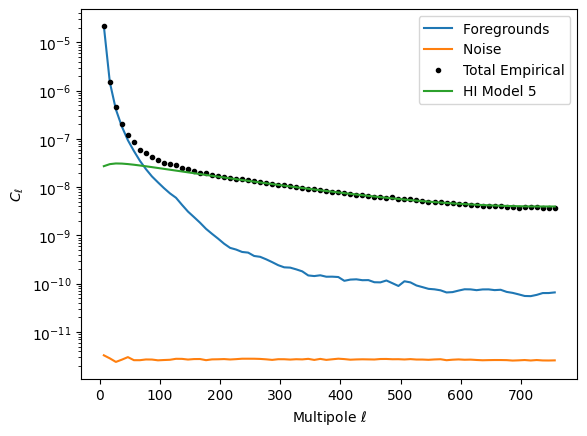

In [485]:
plt.plot(leff,fgds_binned[:,26,26], label='Foregrounds ')
plt.plot(leff,noise_binned[:,26,26], label='Noise   ')
plt.plot(leff,chat_binned_new[:,26,26],'k.', label='Total Empirical')

# C_total= (hi_binned + fgds_binned + noise_binned)/np.linalg.norm(total)
# plt.plot(leff,C_total[:,20,20], label='total')

plt.plot(leff,C_fit_binned[:,26,26], label='HI Model 5')
# plt.plot(leff,hi_d[:,26,26],'-', label='hi true')
plt.yscale('log')
plt.xlabel(r'Multipole $\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.legend()

In [480]:
freqs[26]

np.int64(804)

Mean Squared Error Optimization

In [403]:
noise_diag=np.array([np.diag(noise_binned[i]) for i in range(nbins)])#/np.linalg.norm(noise_binned)
fgds_diag=np.array([np.diag(fgds_binned[i]) for i in range(nbins)]) #/np.linalg.norm(fgds_binned)
C_diag_toy=np.array([np.diag(C_fit_binned[i]) for i in range(nbins)])#/np.linalg.norm(C_fit_binned)

total=noise_diag + fgds_diag + C_diag_toy
chat_diag=np.array([np.diag(chat_binned_new[i]) for i in range(nbins)])/np.linalg.norm(total)


Normalizing

In [404]:
nell=nbins
log_ell = np.log10(leff)  # shape (nell,)   

In [405]:
def loss(a):
    a_mat = a.reshape((P + 1, Q + 1))  # reshape into coefficient matrix
    # a_mat=a_mat/np.linalg.norm(a_mat)
    C_model = np.zeros((nell, nfreqs))    # predicted covariance diagonal
    for p in range(P + 1):
        for q in range(Q + 1):
            C_model += a_mat[p, q] * np.outer(log_ell**p, Psi[q])
    r = (((C_model + noise_diag + fgds_diag)/np.linalg.norm(total)- chat_diag)).reshape(-1)   #/np.linalg.norm(C_fit_diag)).reshape(-1)  # residual
    # r=X @ a - y  # residual vector
    return 0.5* np.dot(r, r)           # MSE


def grad_loss(a):
    a_mat = a.reshape((P + 1, Q + 1))
    # a_mat=a_mat/np.linalg.norm(a_mat)
    C_model = np.zeros((nell, nfreqs))
    for p in range(P + 1):
        for q in range(Q + 1):
            C_model += a_mat[p, q] * np.outer(log_ell**p, Psi[q])
    r = ((C_model + noise_diag + fgds_diag)/np.linalg.norm(total) - chat_diag)

    grad = np.zeros_like(a_mat)
    for p in range(P + 1):
        log_term = log_ell**p  # shape (nell,)
        for q in range(Q + 1):
            psi_term = Psi[q]  # shape (nf,)
            grad[p, q] = np.sum(r * np.outer(log_term, psi_term))
    return grad.reshape(-1)

In [406]:
loss(a_vec)

np.float64(2.7406068116741544e-05)

In [407]:
from scipy.optimize import minimize

res1 = minimize(loss,3*a_vec,
               jac=grad_loss,
               method='BFGS',
               options={'disp': True, 'maxls':10000, 'maxfun': 600000,'ftol': 1e-1,'gtol': 1e-7, 'maxiter': 15000}) #, 'maxls':100,'xtol': 1e-15, 'gtol': 1e-15, 'verbose': 2

a_opt1 = res1.x.reshape((P+1, Q+1))

/tmp/ipykernel_420262/4043059279.py:3: OptimizeWarning: Unknown solver options: maxls, maxfun, ftol
  res1 = minimize(loss,3*a_vec,


Optimization terminated successfully.
         Current function value: 0.000026
         Iterations: 92
         Function evaluations: 1788
         Gradient evaluations: 1788


In [408]:
from pprint import pprint

pprint(res1)


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.5830188452262647e-05
        x: [-9.208e-06  9.865e-06 ...  5.489e-09 -1.458e-08]
      nit: 92
      jac: [-4.290e-10 -5.417e-10 ...  1.313e-08 -1.412e-08]
 hess_inv: [[ 4.386e-01 -5.844e-02 ...  2.843e-04  1.093e-03]
            [-5.844e-02  5.703e-01 ...  1.298e-03  2.932e-04]
            ...
            [ 2.843e-04  1.298e-03 ...  1.722e-04 -6.715e-06]
            [ 1.093e-03  2.932e-04 ... -6.715e-06  1.533e-04]]
     nfev: 1788
     njev: 1788


In [499]:
f=45

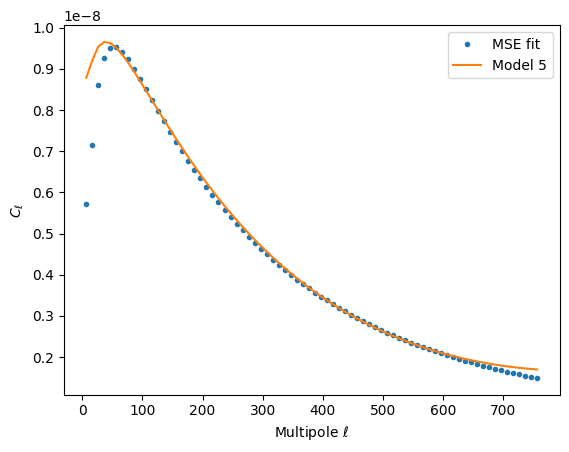

In [503]:
a_new = a_opt1.reshape((P+1, Q+1))
C_new = np.zeros((nell, nfreqs))
for p in range(P + 1):
    for q in range(Q + 1):
        C_new += (a_new[p, q]) * np.outer(log_ell**p, Psi[q])

C_mse = np.zeros((nell, nfreqs, nfreqs))
for i in range(nell):
    np.fill_diagonal(C_mse[i], C_new[i])

plt.plot( leff,C_mse[:,f,f], '.',label='MSE fit')
plt.plot( leff,C_fit_binned[:,f, f],label='Model 5')
# plt.plot(hi_binned[:,f, f],label='data')
plt.ylabel(r'$C_{\ell}$')
plt.xlabel(r'Multipole $\ell$')
# plt.yscale('log')
plt.legend()

In [504]:
freqs[45]

np.int64(994)

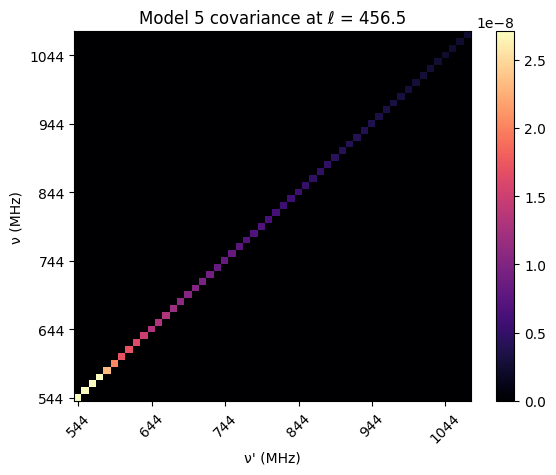

In [523]:
l=45
plt.imshow(C_fit_binned[l], origin='lower', cmap='magma', aspect='auto',)
plt.title(f"Model 5 covariance at ℓ = {leff[l]}")
plt.xlabel("ν' (MHz)")
plt.ylabel("ν (MHz)")
step = 10
xticks = np.arange(0, nfreqs - 1, step)
yticks = xticks

# Labels for spaced ticks
xtick_labels = [f"{freqs[i]}" for i in xticks]
ytick_labels = xtick_labels.copy()

plt.xticks(ticks=xticks, labels=xtick_labels, rotation=45)
plt.yticks(ticks=yticks, labels=ytick_labels)
plt.colorbar()

In [524]:
leff[45]

np.float64(456.5)

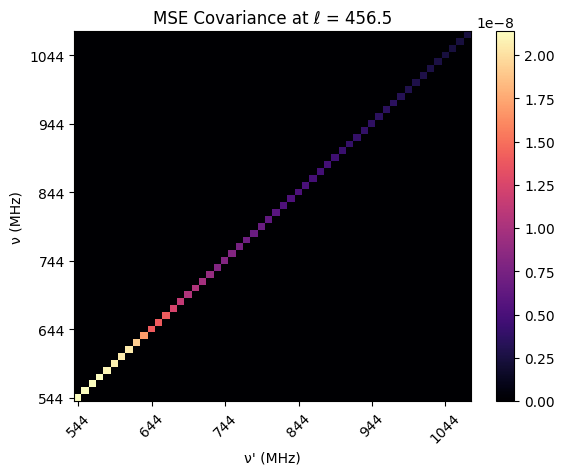

In [525]:
plt.imshow(C_mse[l], origin='lower', cmap='magma', aspect='auto')

plt.title(f"MSE Covariance at ℓ = {leff[l]}")
plt.xlabel("ν' (MHz)")
plt.ylabel("ν (MHz)")
step = 10
xticks = np.arange(0, nfreqs - 1, step)
yticks = xticks

# Labels for spaced ticks
xtick_labels = [f"{freqs[i]}" for i in xticks]
ytick_labels = xtick_labels.copy()

plt.xticks(ticks=xticks, labels=xtick_labels, rotation=45)
plt.yticks(ticks=yticks, labels=ytick_labels)
plt.colorbar()

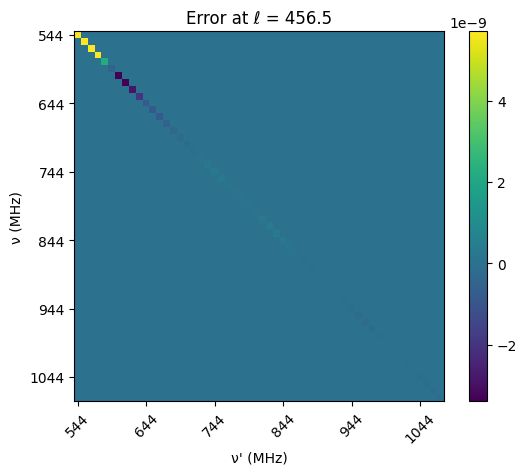

In [526]:
plt.imshow((C_fit_binned[l]-C_mse[l])) #/np.linalg.norm(C_fit_binned)
plt.title(f"Error at ℓ = {leff[l]}")
plt.xlabel("ν' (MHz)")
plt.ylabel("ν (MHz)")
step = 10
xticks = np.arange(0, nfreqs - 1, step)
yticks = xticks

# Labels for spaced ticks
xtick_labels = [f"{freqs[i]}" for i in xticks]
ytick_labels = xtick_labels.copy()

plt.xticks(ticks=xticks, labels=xtick_labels, rotation=45)
plt.yticks(ticks=yticks, labels=ytick_labels)
plt.colorbar()

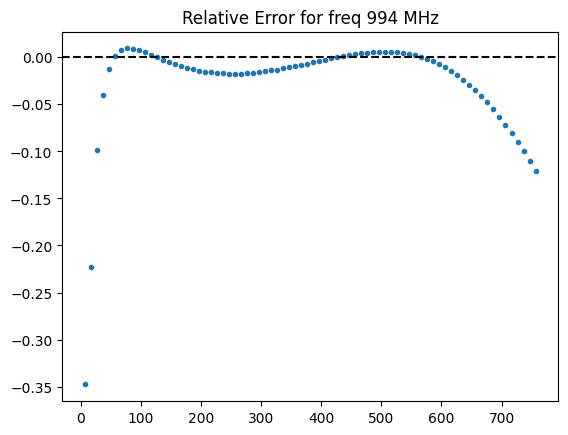

In [532]:
plt.plot(leff,(C_mse[:,f, f]- C_fit_binned[:,f,f])/C_fit_binned[:,f,f], '.',label='error')
plt.title(f"Relative Error for freq {freqs[f]} MHz")
plt.axhline(0, color='k', linestyle='--')

In [415]:
def is_psd(P, tol=0):
    eigenvalues = np.linalg.eigvalsh(P)  # symmetric-optimized
    return np.all(eigenvalues >= -tol) 
print("Is model PSD?", is_psd(chat_binned_new))

Is model PSD? True


SMICA Loss

In [416]:
from numpy.linalg import slogdet, inv

# chat_binned_new=chat_binned_new/np.linalg.norm(chat_binned_new)
scale= np.linalg.norm(noise_binned + fgds_binned +C_fit_binned)
# y=(X@a_vec).reshape((nell, nf))
# C_y = np.zeros((nell, nf, nf))
# for i in range(nell):
#     np.fill_diagonal(C_y[i], y[i])
    
# # Example: equal weight for each ell bin
# n_q = np.ones(nbins)  

# # Or: number of modes in each ell bin
# n_q = np.array([sum(2*l + 1 for l in range(nbins)) 
#                 for b in range(nbins)])

def build_C_model(a):
    # a_mat = a.reshape((P + 1, Q + 1))
    # C_model = np.zeros((nell, nf))    # predicted covariance diagonal
    # for p in range(P + 1):
    #     for q in range(Q + 1):
    #         C_model += a_mat[p, q] * np.outer(log_l**p, Psi[q])
    C_model= X_test@a
    C_model_full = np.zeros((nell, nfreqs, nfreqs))
    for i in range(nell):
        np.fill_diagonal(C_model_full[i], C_model[i])

    return C_model_full


def smica_loss(a):
    
    loss = 0.0
    C_model = build_C_model(a)
    
    for b in range(nbins):
        C_emp = chat_binned_new[b]/scale  # empirical HI covariance at that b
        C_mod = C_model[b]
        C_tot= (C_mod +noise_binned[b] + fgds_binned[b])/scale

        sign, logdet = slogdet(C_emp @ np.linalg.inv(C_tot))
        # if sign <= 0:
        #     return np.inf  # invalid logdet => reject this parameter set
        trace_term = np.trace(C_emp @ np.linalg.inv(C_tot))
        loss +=  (trace_term - logdet - nfreqs)
    return loss


def jacobian(a):

    C_model = build_C_model(a)  # shape (nell, nf, nf)
    grad = np.zeros((P+1, Q+1))

    for b in range(nbins):
        C_emp = chat_binned_new[b]/scale       # empirical (nf, nf)
        C_mod = C_model[b]  
        C_tot= (C_mod +noise_binned[b] + fgds_binned[b])/scale
        C_tot_inv= np.linalg.inv(C_tot)

        sign, logdet = slogdet(C_emp @ C_tot_inv)
        

        Delta = C_tot_inv - C_tot_inv @ C_emp @ C_tot_inv  # (nf, nf)

        for p in range(P+1):
            for q in range(Q+1):
                dR = np.zeros_like(C_mod)
                diag_val = (log_ell[b]**p) * Psi[q]  # length nf
                np.fill_diagonal(dR, diag_val)
                grad[p, q] += np.trace(Delta @ dR)  # multiply by n_q[b] if needed

    return grad.reshape(-1)



In [417]:
smica_loss(a_vec)

np.float64(12814.364937656812)

In [418]:
def is_psd(P, tol=0):
    eigenvalues = np.linalg.eigvalsh(P)  # symmetric-optimized
    return np.all(eigenvalues >= -tol) 
print("Is model PSD?", is_psd(chat_binned_new))

Is model PSD? True


Using the result from MSE optimization in SMICA

In [419]:
from scipy.optimize import minimize

res2 = minimize(smica_loss,res1.x,
               jac=jacobian,
               method='BFGS',
               options={'disp': True,'maxls':100000,'ftol':1e-6, 'gtol':1e-1,'xtol':1e-5, 'eps': 1e-1, 'maxiter': 10000, 'verbose':2}) #,'xtol':1e-5, 'eps': 1e-1, 'maxls':100,'xtol': 1e-15, 'gtol': 1e-15, 'verbose': 2  'maxfun': 600000,'ftol': 1e-2, 'maxls':100000, 'gtol': 1e-3,

a_opt2 = res2.x.reshape((P+1, Q+1))

/tmp/ipykernel_420262/337383780.py:3: OptimizeWarning: Unknown solver options: maxls, ftol, xtol, verbose
  res2 = minimize(smica_loss,res1.x,


         Current function value: 9425.964698
         Iterations: 0
         Function evaluations: 113
         Gradient evaluations: 101


/home/iloveorcas/.local/lib/python3.10/site-packages/scipy/optimize/_minimize.py:733: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [420]:
from pprint import pprint

pprint(res2)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 9425.9646983624
        x: [-9.208e-06  9.865e-06 ...  5.489e-09 -1.458e-08]
      nit: 0
      jac: [-6.731e+07 -4.403e+07 ... -1.917e+09 -2.026e+09]
 hess_inv: [[1 0 ... 0 0]
            [0 1 ... 0 0]
            ...
            [0 0 ... 1 0]
            [0 0 ... 0 1]]
     nfev: 113
     njev: 101


In [466]:
freqs[40]

np.int64(944)

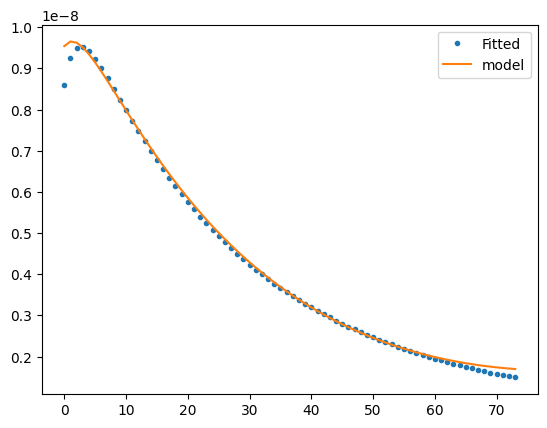

In [533]:
f=45
a_smica= a_opt2.reshape((P+1, Q+1))
C_smica_d= np.zeros((nell, nfreqs))
for p in range(P + 1):
    for q in range(Q + 1):
        C_smica_d += (a_smica[p, q]) * np.outer(log_ell**p, Psi[q])
C_smica = np.zeros((nell, nfreqs, nfreqs))
for i in range(nell):
    np.fill_diagonal(C_smica[i], C_smica_d[i])


plt.plot( C_smica[2:,f,f], '.',label='Fitted')
plt.plot( C_fit_binned[2:,f,f], label='model')
# plt.plot(hi_binned[:,f,f], label='data')
plt.legend()

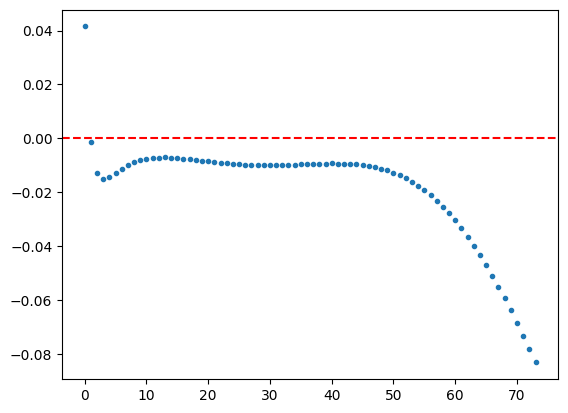

In [423]:
plt.plot((C_smica[2:,f,f]-C_fit_binned[2:,f,f])/C_fit_binned[2:,f,f], '.',label='Error')
plt.axhline(0, color='r', linestyle='--')

In [475]:
freqs[0]

np.int64(544)

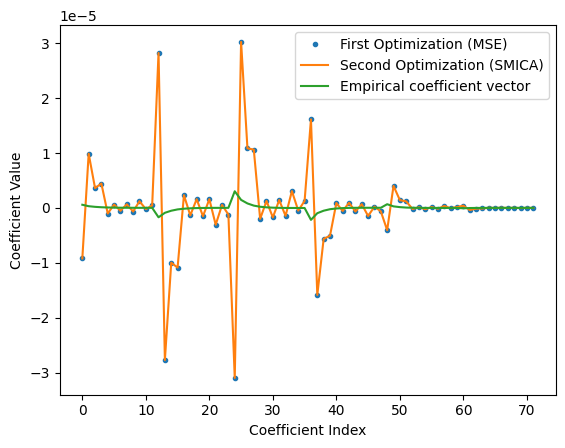

In [535]:
plt.plot(res1.x, '.',label='First Optimization (MSE)')
plt.plot(res2.x, '-',label='Second Optimization (SMICA)')
plt.plot(a_vec,label='Empirical coefficient vector')
plt.ylabel('Coefficient Value')
plt.xlabel('Coefficient Index')
plt.legend()
# plt.ylim(4e-6, -4e-6)

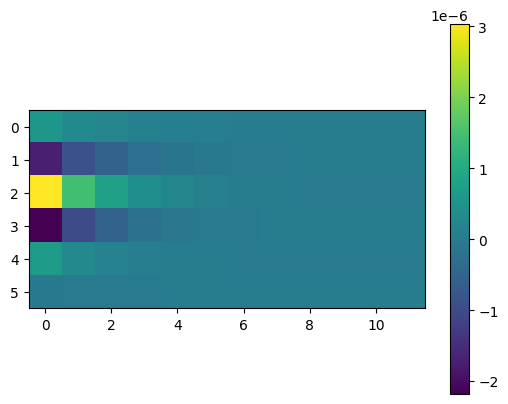

In [450]:
plt.imshow(a_matrix, label='Initial Guess')
plt.colorbar()

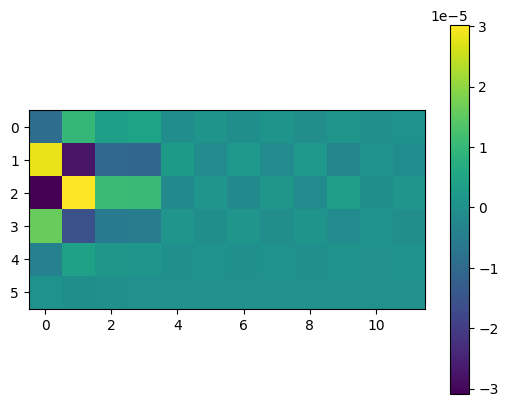

In [463]:
plt.imshow(a_opt1, label='First Optimization (MSE)')
plt.colorbar()

EXTRAAAA

In [ ]:
# np.allclose(C_fit,build_C_model(a_vec))

In [ ]:
# np.min(np.linalg.eigvalsh(build_C_model(a_vec)))

Gradient Descent

In [ ]:
# a_current = 2* a_vec
# alpha = 1e-14
# tol_grad=1e-2

# for i in range(100000):
#     loss_current = smica_loss(a_current)
#     grad_current = jacobian(a_current)
#     grad_norm = np.linalg.norm(grad_current)
    
#     # if grad_norm > 1e3:  # clip gradient norm or scale step
#     #     grad_current = grad_current / grad_norm * 1e3
    
#     a_current = a_current - alpha * grad_current

#     if i % 1000 == 0:
#         print(f"Step {i}, loss = {loss_current:.6e}, grad norm = {grad_norm:.3e}")
#     if np.linalg.norm(grad_current) < tol_grad:
#         print(f"Stopping at iter {i}: gradient small.")
#         break



In [ ]:
# a_d= a_current.reshape((P+1, Q+1))
# C_d= np.zeros((nell, nf))
# for p in range(P + 1):
#     for q in range(Q + 1):
#         C_d += (a_d[p, q]) * np.outer(log_l**p, Psi[q])



# plt.plot( C_d[:,26], '.',label='Fitted')
# plt.plot( C_fit_diag[:,26], label='model')
# plt.legend()